# 4. Function Integration - Complete Pipeline

This notebook integrates OCR and LLM processing functions from notebooks 2 and 3 into a complete, production-ready document processing pipeline.

> **📖 For detailed explanations** of the system architecture, technology choices, and learning resources, see the [README.md](./README.md) in this folder.

**Functions Moved to src/ Modules**

All functions from notebooks 2 and 3 have been moved to the `src/` folder structure:
- **OCR functions** → `src/ocr/`
- **LLM functions** → `src/llm/`
- **Storage functions** → `src/storage/`

This allows for proper code organization and reusability across the project.

### What We'll Build

We'll create a complete document processing pipeline:
- **Blob storage integration** with standardized data structures
- **Visualization pipeline** with confidence scoring
- **Production-ready architecture** with error handling and logging

## 1. Prerequisites & Setup

**Required:** Complete notebooks 01, 02, and 03
**Services:** Docker containers running (PostgreSQL, Ollama, Azurite)
**Libraries:** All dependencies from previous notebooks

> Start notebook 01 to run the docker containers

### Quick Pipeline Overview

**Document Processing Pipeline** orchestrates multiple processing stages with proper state management and storage.

In [14]:
# Standard Library Imports
import asyncio
import json
import logging
import sys
import re
from datetime import datetime
from typing import Dict, Any, List, Protocol
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

# Add project root to Python path so we can import from src/
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

In [15]:
# Force reload modules
if 'src.ocr.postprocess' in sys.modules:
    del sys.modules['src.ocr.postprocess']
if 'src.ocr.easyocr_client' in sys.modules:
    del sys.modules['src.ocr.easyocr_client']

# Import functions from notebook 02 - OCR Text Extraction
from src.ocr.easyocr_client import extract_text_bboxes_with_ocr
from src.ocr.postprocess import normalize_ocr_lines, convert_numpy_types

# Import functions from notebook 03 - LLM Field Extraction  
from src.llm.field_extractor import extract_fields_with_llm
from src.llm.client import OllamaClient, GenerativeLlm
from src.llm.config import load_document_config

# Import storage functions
from src.storage.storage import get_storage, Stage

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### 1.2 Document Processing Stages and Storage Architecture

#### Processing Stages

Our credit OCR system uses a **state machine pattern** with four distinct processing stages:

**1. `Stage.RAW` - Original Document Storage**
- Stores the original PDF files as uploaded
- Serves as the source of truth for document processing
- Example: `loan_application.pdf`

**2. `Stage.OCR` - OCR Processing Results**
- Stores structured OCR data extracted from PDFs
- Contains text elements, bounding boxes, and confidence scores
- Example: `document_id.json` with OCR results

**3. `Stage.LLM` - LLM Field Extraction Results**
- Stores field extraction results from LLM analysis
- Contains extracted fields, validation results, and confidence scores
- Example: `document_id.json` with extracted loan data

**4. `Stage.ANNOTATED` - Visual Annotations**
- Stores visualization images with OCR bounding boxes
- Used for debugging, validation, and quality assurance
- Example: `document_id_page_1.png` with highlighted text regions

#### Why Use Stages?

**Separation of Concerns:**
- Each stage has a specific purpose and data format
- Easy to debug and troubleshoot individual processing steps
- Clear audit trail of document processing pipeline

**Scalability:**
- Different stages can be processed by different services
- Easy to add new processing stages (e.g., validation, approval)
- Parallel processing of multiple documents

**Data Integrity:**
- Original documents are never modified
- Each stage builds upon the previous one
- Easy to reprocess from any stage if needed

#### Storage Architecture

**Blob Storage Structure:**
```
raw/           # Original PDFs
ocr/           # OCR processing results
llm/           # LLM field extraction results
annotated/     # Visualization images
```

**Data Formats:**
- **Raw files**: Binary PDF data
- **Processing results**: Standardized JSON with metadata
- **Visualizations**: PNG images with OCR overlays

**Storage Client Methods:**
- **`upload_blob()`**: For raw binary data (PDFs, images)
- **`upload_document_data()`**: For structured JSON data with metadata
- **`download_blob()`**: Retrieve raw binary data
- **`download_document_data()`**: Retrieve and parse structured data

**Benefits:**
- **Consistent data structure** across all processing stages
- **Automatic metadata** (timestamps, document IDs)
- **Type safety** with clear interfaces
- **Error handling** and logging built-in
- **Easy testing** and debugging

In [16]:
# Upload the loan application PDF to blob storage using the storage client
document_id = "test-document-001"
filename = "loan_application.pdf"

# Load file from data folder
file_path = project_root / "data" / filename
with open(file_path, "rb") as f:
    file_data = f.read()

# Upload to blob storage using the storage client
storage_client = get_storage()
storage_client.upload_blob(
    uuid=document_id,
    stage=Stage.RAW,
    ext=".pdf",
    data=file_data,
    overwrite=True
)

blob_path = storage_client.blob_path(document_id, Stage.RAW, ".pdf")
print(f"File successfully uploaded to blob storage at: {Stage.RAW.value}/{blob_path}")

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/raw/test-document-001.pdf'
Request method: 'PUT'
Request headers:
    'Content-Length': '147568'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Content-Type': 'application/octet-stream'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '10905e9e-8f13-11f0-a729-0b960ac85e15'
    'Authorization': 'REDACTED'
A body is sent with the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 201
Response headers:
    'Server': 'Azurite-Blob/3.34.0'
    'etag': '"0x234A10F3C7A4840"'
    'last-modified': 'Thu, 11 Sep 2025 13:27:29 GMT'
    'content-md5': 'REDACTED'
    'x-ms-client-request-id': '10905e9e-8f13-11f0-a729-0b960ac85e15'
    'x-ms-request-id': '1d6f9ea7-2eea-4148-8984-7c87fc749e0b'
    'x-ms-versio

Uploaded blob: raw/test-document-001.pdf
File successfully uploaded to blob storage at: raw/test-document-001.pdf


## 2. Configuration Management

### 2.1 System Configuration Loading

Load system configuration from the config file to get LLM settings.

**Configuration Sources:**
- `config/credit-ocr-system.conf`: System-wide settings (LLM URL, model name)
- `config/document_types.conf`: Document-specific field definitions

In [17]:
def load_system_config():
    """Load system configuration from config file."""
    with open("../../config/credit-ocr-system.conf", 'r') as f:
        content = f.read()
    
    llm_match = re.search(r'generative_llm\s*\{\s*url\s*=\s*"([^"]+)"\s*model_name\s*=\s*"([^"]+)"\s*\}', content, re.DOTALL)
    if llm_match:
        return {
            'llm': {
                'url': llm_match.group(1),
                'model_name': llm_match.group(2)
            }
        }
    return {}

## 3. Integrated Pipeline Architecture

### 3.1 Why Build an Integrated Pipeline?

In the previous notebooks, we developed individual components for OCR processing and LLM field extraction. Now we need to combine these into a cohesive system that can process documents end-to-end. The integrated pipeline serves as the orchestrator that coordinates all processing steps while maintaining the modularity we've built.

The pipeline handles the complete document lifecycle: from raw PDF upload through OCR text extraction, LLM field mapping, visualization generation, and structured data storage. This approach ensures that each document follows a consistent processing path while allowing us to track progress, debug issues, and maintain data integrity throughout the workflow.

Rather than having separate scripts for each processing step, the integrated pipeline provides a single entry point that manages the entire document processing workflow. This makes it easier to deploy, monitor, and maintain the system in production environments.

### 3.2 Modular Function Design

The pipeline is built using modular functions rather than one monolithic process. This design choice reflects real-world software engineering practices where complex systems are broken down into manageable, testable components.

Each processing function has a single responsibility: OCR processing, LLM field extraction, or visualization generation. This separation allows us to test each component independently, reuse functions in different contexts, and make changes to one part without affecting others. For example, if we want to switch from EasyOCR to a different OCR engine, we only need to modify the OCR processing function.

The modular approach also makes debugging much easier. When something goes wrong, we can isolate the issue to a specific function rather than searching through hundreds of lines of code. Additionally, this design makes it straightforward to add new processing steps or modify existing ones without disrupting the entire pipeline.

### 3.3 OCR Processing Function

The OCR processing function encapsulates all the text extraction logic we developed in notebook 2. It takes raw PDF data and returns structured OCR results along with the extracted text elements. The function handles the complete OCR workflow: text detection, normalization, and data preparation for storage.

This function demonstrates how we can package complex processing logic into a reusable component. The OCR processing includes error handling, progress logging, and data conversion to ensure the results are ready for the next processing stage.

In [18]:
async def process_document_with_ocr(document_id: str, pdf_data: bytes) -> Dict[str, Any]:
    """Process document with OCR and save results to blob storage."""
    print(f"Processing document {document_id} with OCR...")
    
    # Step 1: OCR Processing
    print("  - Extracting text with OCR...")
    ocr_results, pdf_images = extract_text_bboxes_with_ocr(pdf_data)
    print(f"  - Extracted {len(ocr_results)} text elements")
    
    # Step 2: Normalize OCR results
    print("  - Normalizing OCR results...")
    normalized_results = normalize_ocr_lines(ocr_results)
    print(f"  - Normalized to {len(normalized_results)} structured items")
    
    # Step 3: Convert NumPy types
    print("  - Converting NumPy types...")
    ocr_results_converted = convert_numpy_types(ocr_results)
    normalized_results_converted = convert_numpy_types(normalized_results)
    
    # Step 4: Prepare OCR results
    ocr_processing_results = {
        "document_id": document_id,
        "timestamp": datetime.now().isoformat(),
        "original_lines": ocr_results_converted,
        "normalized_lines": normalized_results_converted,
        "total_elements": len(ocr_results_converted),
        "structured_items": len(normalized_results_converted)
    }
    
    # Step 5: Save OCR results to blob storage
    print("  - Saving OCR results to blob storage...")
    storage_client = get_storage()
    storage_client.upload_document_data(
        uuid=document_id,
        stage=Stage.OCR,
        ext=".json",
        data=ocr_processing_results,
        metadata={}
    )
    
    ocr_blob_path = storage_client.blob_path(document_id, Stage.OCR, ".json")
    print(f"  - OCR results saved to: {Stage.OCR.value}/{ocr_blob_path}")
    
    return ocr_processing_results

### 3.4 LLM Field Extraction Function

The LLM field extraction function builds upon the work from notebook 3, taking normalized OCR text and extracting structured field data using our configured language model. This function manages the LLM client initialization, prompt generation, and result processing.

By encapsulating the LLM processing logic, we create a clean interface that handles all the complexity of communicating with the language model while providing a simple function signature for the rest of the pipeline to use.

In [19]:
async def process_document_with_llm(document_id: str, ocr_results: Dict[str, Any]) -> Dict[str, Any]:
    """Process document with LLM field extraction and save results to blob storage."""
    print(f"Processing document {document_id} with LLM...")
    
    # Step 1: Load configuration
    print("  - Loading configuration...")
    system_config = load_system_config()
    doc_config = load_document_config("../../config/document_types.conf")
    
    # Step 2: Initialize LLM client
    print("  - Initializing LLM client...")
    llm_client = OllamaClient(
        base_url=system_config['llm']['url'],
        model_name=system_config['llm']['model_name']
    )
    
    # Step 3: Extract fields using LLM
    print("  - Extracting fields with LLM...")
    extraction_result = await extract_fields_with_llm(
        ocr_lines=ocr_results["normalized_lines"],
        doc_config=doc_config["credit_request"],
        llm_client=llm_client,
        original_ocr_lines=ocr_results["original_lines"]
    )
    
    # Step 4: Prepare LLM results
    llm_processing_results = {
        "document_id": document_id,
        "timestamp": datetime.now().isoformat(),
        "extracted_fields": extraction_result.get("extracted_fields", {}),
        "missing_fields": extraction_result.get("missing_fields", []),
        "validation_results": extraction_result.get("validation_results", {}),
        "llm_metadata": {
            "model_used": system_config['llm']['model_name'],
            "extraction_method": "llm_assisted"
        }
    }
    
    # Step 5: Save LLM results to blob storage
    print("  - Saving LLM results to blob storage...")
    storage_client = get_storage()
    storage_client.upload_document_data(
        uuid=document_id,
        stage=Stage.LLM,
        ext=".json",
        data=llm_processing_results,
        metadata={
            "processing_method": system_config['llm']['model_name']
        }
    )
    
    llm_blob_path = storage_client.blob_path(document_id, Stage.LLM, ".json")
    print(f"  - LLM results saved to: {Stage.LLM.value}/{llm_blob_path}")
    
    return llm_processing_results


### 3.5 Visualization Function

The visualization function creates visual representations of the OCR results, showing bounding boxes and confidence scores overlaid on the original document images. This function is particularly valuable for debugging OCR issues and validating the quality of text extraction.

The visualization serves as a quality assurance tool, allowing us to quickly identify areas where OCR confidence is low or where text extraction might have failed. By storing these visualizations in blob storage, we create a permanent record that can be reviewed later for system improvement.

In [20]:
# Visualization function from notebook 02
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [21]:
def visualize_ocr_results(document_id: str, ocr_results: List[Dict[str, Any]]) -> None:
    """Visualize OCR bounding boxes, text, and confidence on images and save to blob storage."""
    from io import BytesIO
    from pdf2image import convert_from_bytes
    
    # Download PDF from blob storage
    storage_client = get_storage()
    pdf_data = storage_client.download_blob(document_id, Stage.RAW, ".pdf")
    if pdf_data is None:
        raise FileNotFoundError(f"PDF not found in blob storage: {document_id}")
    
    # Convert PDF to images with SAME DPI as OCR processing (150)
    print("  - Converting PDF to images for visualization...")
    pdf_images = convert_from_bytes(pdf_data, dpi=150)  # Changed from 200 to 150
    print(f"  - Converted PDF to {len(pdf_images)} images")
    
    # Group OCR results by page
    page_to_elements: Dict[int, List[Dict[str, Any]]] = {}
    for result in ocr_results:
        page_num: int = result["page_num"]
        if page_num not in page_to_elements:
            page_to_elements[page_num] = []
        page_to_elements[page_num].append(result)
    
    # Create visualizations for each page
    for page_num, elements in page_to_elements.items():
        image = pdf_images[page_num - 1]
        fig, ax = plt.subplots(1, 1, figsize=(15, 20))
        ax.imshow(image)
        ax.set_title(f'Page {page_num} - OCR Text Extraction', fontsize=16)
        
        for element in elements:
            bbox = element['bbox']
            text = element['text']
            confidence = element['confidence']
            color = 'green' if confidence >= 0.9 else 'orange' if confidence >= 0.7 else 'red'
            
            rect = patches.Rectangle(
                (bbox['x1'], bbox['y1']),
                bbox['width'],
                bbox['height'],
                linewidth=1.5,
                edgecolor=color,
                facecolor='none',
                alpha=0.8
            )
            ax.add_patch(rect)
            
            display_text = text[:30] + ('...' if len(text) > 30 else '')
            label = f"{display_text} ({confidence*100:.1f}%)"
            ax.annotate(
                label,
                (bbox['x1'], bbox['y1'] - 5),
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.9),
                fontsize=7,
                color='black',
                ha='left',
                va='bottom'
            )
        
        legend_elements = [
            patches.Patch(color='green', label='High (≥90%)'),
            patches.Patch(color='orange', label='Med (70-89%)'),
            patches.Patch(color='red', label='Low (<70%)')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        ax.set_xlim(0, image.width)
        ax.set_ylim(image.height, 0)
        ax.axis('off')
        plt.tight_layout()
        
        # Save visualization to blob storage
        buffer = BytesIO()
        plt.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
        buffer.seek(0)
        
        # Upload to blob storage with ANNOTATED stage
        storage_client.upload_blob(
            uuid=document_id,
            stage=Stage.ANNOTATED,
            ext=f"_page_{page_num}.png",
            data=buffer.getvalue(),
            overwrite=True
        )
        
        annotated_blob_path = storage_client.blob_path(document_id, Stage.ANNOTATED, f"_page_{page_num}.png")
        print(f"  - Visualization saved to: {Stage.ANNOTATED.value}/{annotated_blob_path}")
        
        plt.show()
        plt.close()  # Close the figure to free memory
        
        high = sum(1 for e in elements if e['confidence'] >= 0.9)
        med = sum(1 for e in elements if 0.7 <= e['confidence'] < 0.9)
        low = sum(1 for e in elements if e['confidence'] < 0.7)
        avg = sum(e['confidence'] for e in elements) / len(elements) if elements else 0
        print(f"Page {page_num}: {len(elements)} elements | Avg: {avg*100:.1f}% | H:{high} M:{med} L:{low}")

### 3.6 Complete Integrated Pipeline

The integrated pipeline function orchestrates all the processing steps we've built. It demonstrates how to coordinate multiple processing functions while maintaining proper error handling, logging, and data flow between stages.

This function shows the practical application of our modular design. Rather than duplicating code, it calls our specialized processing functions and combines their results into a comprehensive document processing workflow. The pipeline also handles the storage of intermediate results, ensuring that we can resume processing from any stage if needed.

In [22]:
async def integrated_pipeline(document_id: str, filename: str, blob_path: str):
    """Complete integrated pipeline combining document loading from blob storage, OCR and LLM processing."""
    
    print(f"Starting integrated pipeline for document: {document_id}")
    print(f"  - Filename: {filename}")
    print(f"  - Blob path: {blob_path}")
    
    # Step 1: Load document from blob storage
    print("Step 1: Loading document from blob storage...")
    storage_client = get_storage()
    pdf_data = storage_client.download_blob(document_id, Stage.RAW, ".pdf")
    if pdf_data is None:
        raise FileNotFoundError(f"Document not found in blob storage: {document_id}")
    print(f"  - Loaded {filename} from blob storage ({len(pdf_data)} bytes)")
    
    # Step 2: OCR Processing using modular function
    print("Step 2: OCR Processing...")
    ocr_results = await process_document_with_ocr(document_id, pdf_data)
    
    # Step 3: LLM Processing using modular function
    print("Step 3: LLM Field Extraction...")
    llm_results = await process_document_with_llm(document_id, ocr_results)
    
    # Step 4: Visualize OCR results
    print("Step 4: Visualizing OCR results...")
    visualize_ocr_results(document_id, ocr_results["original_lines"])
    
    # Step 5: Prepare final results
    final_results = {
        "document_id": document_id,
        "timestamp": datetime.now().isoformat(),
        "document_info": {
            "filename": filename,
            "file_size": len(pdf_data),
            "source": "blob_storage",
            "blob_path": blob_path
        },
        "ocr_results": ocr_results,
        "llm_results": llm_results,
        "status": "completed"
    }
    
    print("Step 5: Pipeline completed successfully!")
    print(f"  - Extracted {len(llm_results.get('extracted_fields', {}))} fields")
    print(f"  - Missing {len(llm_results.get('missing_fields', []))} fields")
    
    return final_results

---

## 4. Pipeline Execution

### 4.1 Testing the Complete Workflow

Now that we have built all the processing functions, it's time to execute the complete pipeline and see how all the components work together. This section demonstrates the practical application of our integrated system by processing a real document through all stages.

We'll use the loan application PDF that was uploaded to blob storage earlier, processing it through OCR text extraction, LLM field mapping, and visualization generation. This gives us a complete end-to-end test of the system's capabilities.

### 4.2 Document Setup

Before running the pipeline, we need to specify which document to process. The pipeline expects a document that has already been uploaded to blob storage, along with its metadata. This approach simulates a real-world scenario where documents are first uploaded to the system before processing begins.

The document ID, filename, and blob path provide all the information needed to locate and process the document through the complete workflow.

In [23]:
# Use the document that was uploaded to blob storage
document_id = "test-document-001"
filename = "loan_application.pdf"
blob_path = f"{Stage.RAW.value}/{document_id}.pdf"

### 4.3 Pipeline Execution

This is where we put everything together and run the complete document processing pipeline. The execution will:

1. **Load the document** from blob storage
2. **Process with OCR** to extract text and bounding boxes
3. **Extract fields with LLM** to map text to structured data
4. **Generate visualizations** showing OCR results with confidence scores
5. **Store all results** in organized blob storage containers

The pipeline execution provides detailed logging so you can follow the progress through each processing stage. This transparency is crucial for debugging and understanding how the system processes documents.

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/raw/test-document-001.pdf'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '109b20ea-8f13-11f0-a729-0b960ac85e15'
    'Authorization': 'REDACTED'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Server': 'Azurite-Blob/3.34.0'
    'last-modified': 'Thu, 11 Sep 2025 13:27:29 GMT'
    'x-ms-creation-time': 'REDACTED'
    'content-length': '147568'
    'content-type': 'application/octet-stream'
    'content-range': 'REDACTED'
    'etag': '"0x234A10F3C7A4840"'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    

Starting integrated pipeline for document: test-document-001
  - Filename: loan_application.pdf
  - Blob path: raw/test-document-001.pdf
Step 1: Loading document from blob storage...
Downloaded blob: raw/test-document-001.pdf
  - Loaded loan_application.pdf from blob storage (147568 bytes)
Step 2: OCR Processing...
Processing document test-document-001 with OCR...
  - Extracting text with OCR...


INFO:src.ocr.easyocr_client:Processing PDF from bytes (size: 147568 bytes)
INFO:src.ocr.easyocr_client:Successfully converted PDF to 1 images
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/ocr/test-document-001.json'
Request method: 'PUT'
Request headers:
    'Content-Length': '26698'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Content-Type': 'application/octet-stream'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '123ceece-8f13-11f0-a729-0b960ac85e15'
    'Authorization': 'REDACTED'
A body is sent with the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 201
Response headers:
    'Server': 'Azurite-Blob/3.34.0'
    'etag': '"0x235F2593E2108E0"'
    'last-modified': 'Thu, 11 Sep 2025 13:27:32 GMT'
    'content-md5': 'REDACTED'
    '

  - Extracted 62 text elements
  - Normalizing OCR results...
  - Normalized to 26 structured items
  - Converting NumPy types...
  - Saving OCR results to blob storage...
Uploaded blob: ocr/test-document-001.json
  - OCR results saved to: ocr/test-document-001.json
Step 3: LLM Field Extraction...
Processing document test-document-001 with LLM...
  - Loading configuration...
  - Initializing LLM client...
  - Extracting fields with LLM...


INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/llm/test-document-001.json'
Request method: 'PUT'
Request headers:
    'Content-Length': '6317'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Content-Type': 'application/octet-stream'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '32a1bc4e-8f13-11f0-a729-0b960ac85e15'
    'Authorization': 'REDACTED'
A body is sent with the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 201
Response headers:
    'Server': 'Azurite-Blob/3.34.0'
    'etag': '"0x26828189C1F2940"'
    'last-modified': 'Thu, 11 Sep 2025 13:28:26 GMT'
    'content-md5': 'REDACTED'
    'x-ms-client-request-id': '32a1bc4e-8f13-11f0-a729-0b960ac85e15'
    'x-ms-request-id': '0714424f-50ba-4ca2-88f3-383ac4ca8a37'
    'x-ms-version

  - Saving LLM results to blob storage...
Uploaded blob: llm/test-document-001.json
  - LLM results saved to: llm/test-document-001.json
Step 4: Visualizing OCR results...
Downloaded blob: raw/test-document-001.pdf
  - Converting PDF to images for visualization...
  - Converted PDF to 1 images


INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://127.0.0.1:10000/devstoreaccount1/annotated/test-document-001._page_1.png'
Request method: 'PUT'
Request headers:
    'Content-Length': '897486'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Content-Type': 'application/octet-stream'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-blob/12.26.0 Python/3.10.16 (macOS-15.1-arm64-arm-64bit)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '32f727e2-8f13-11f0-a729-0b960ac85e15'
    'Authorization': 'REDACTED'
A body is sent with the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 201
Response headers:
    'Server': 'Azurite-Blob/3.34.0'
    'etag': '"0x2128451DDE01080"'
    'last-modified': 'Thu, 11 Sep 2025 13:28:27 GMT'
    'content-md5': 'REDACTED'
    'x-ms-client-request-id': '32f727e2-8f13-11f0-a729-0b960ac85e15'
    'x-ms-request-id': 'ab259afd-1524-4f57-ade2-565d46401f6e'
  

Uploaded blob: annotated/test-document-001._page_1.png
  - Visualization saved to: annotated/test-document-001._page_1.png


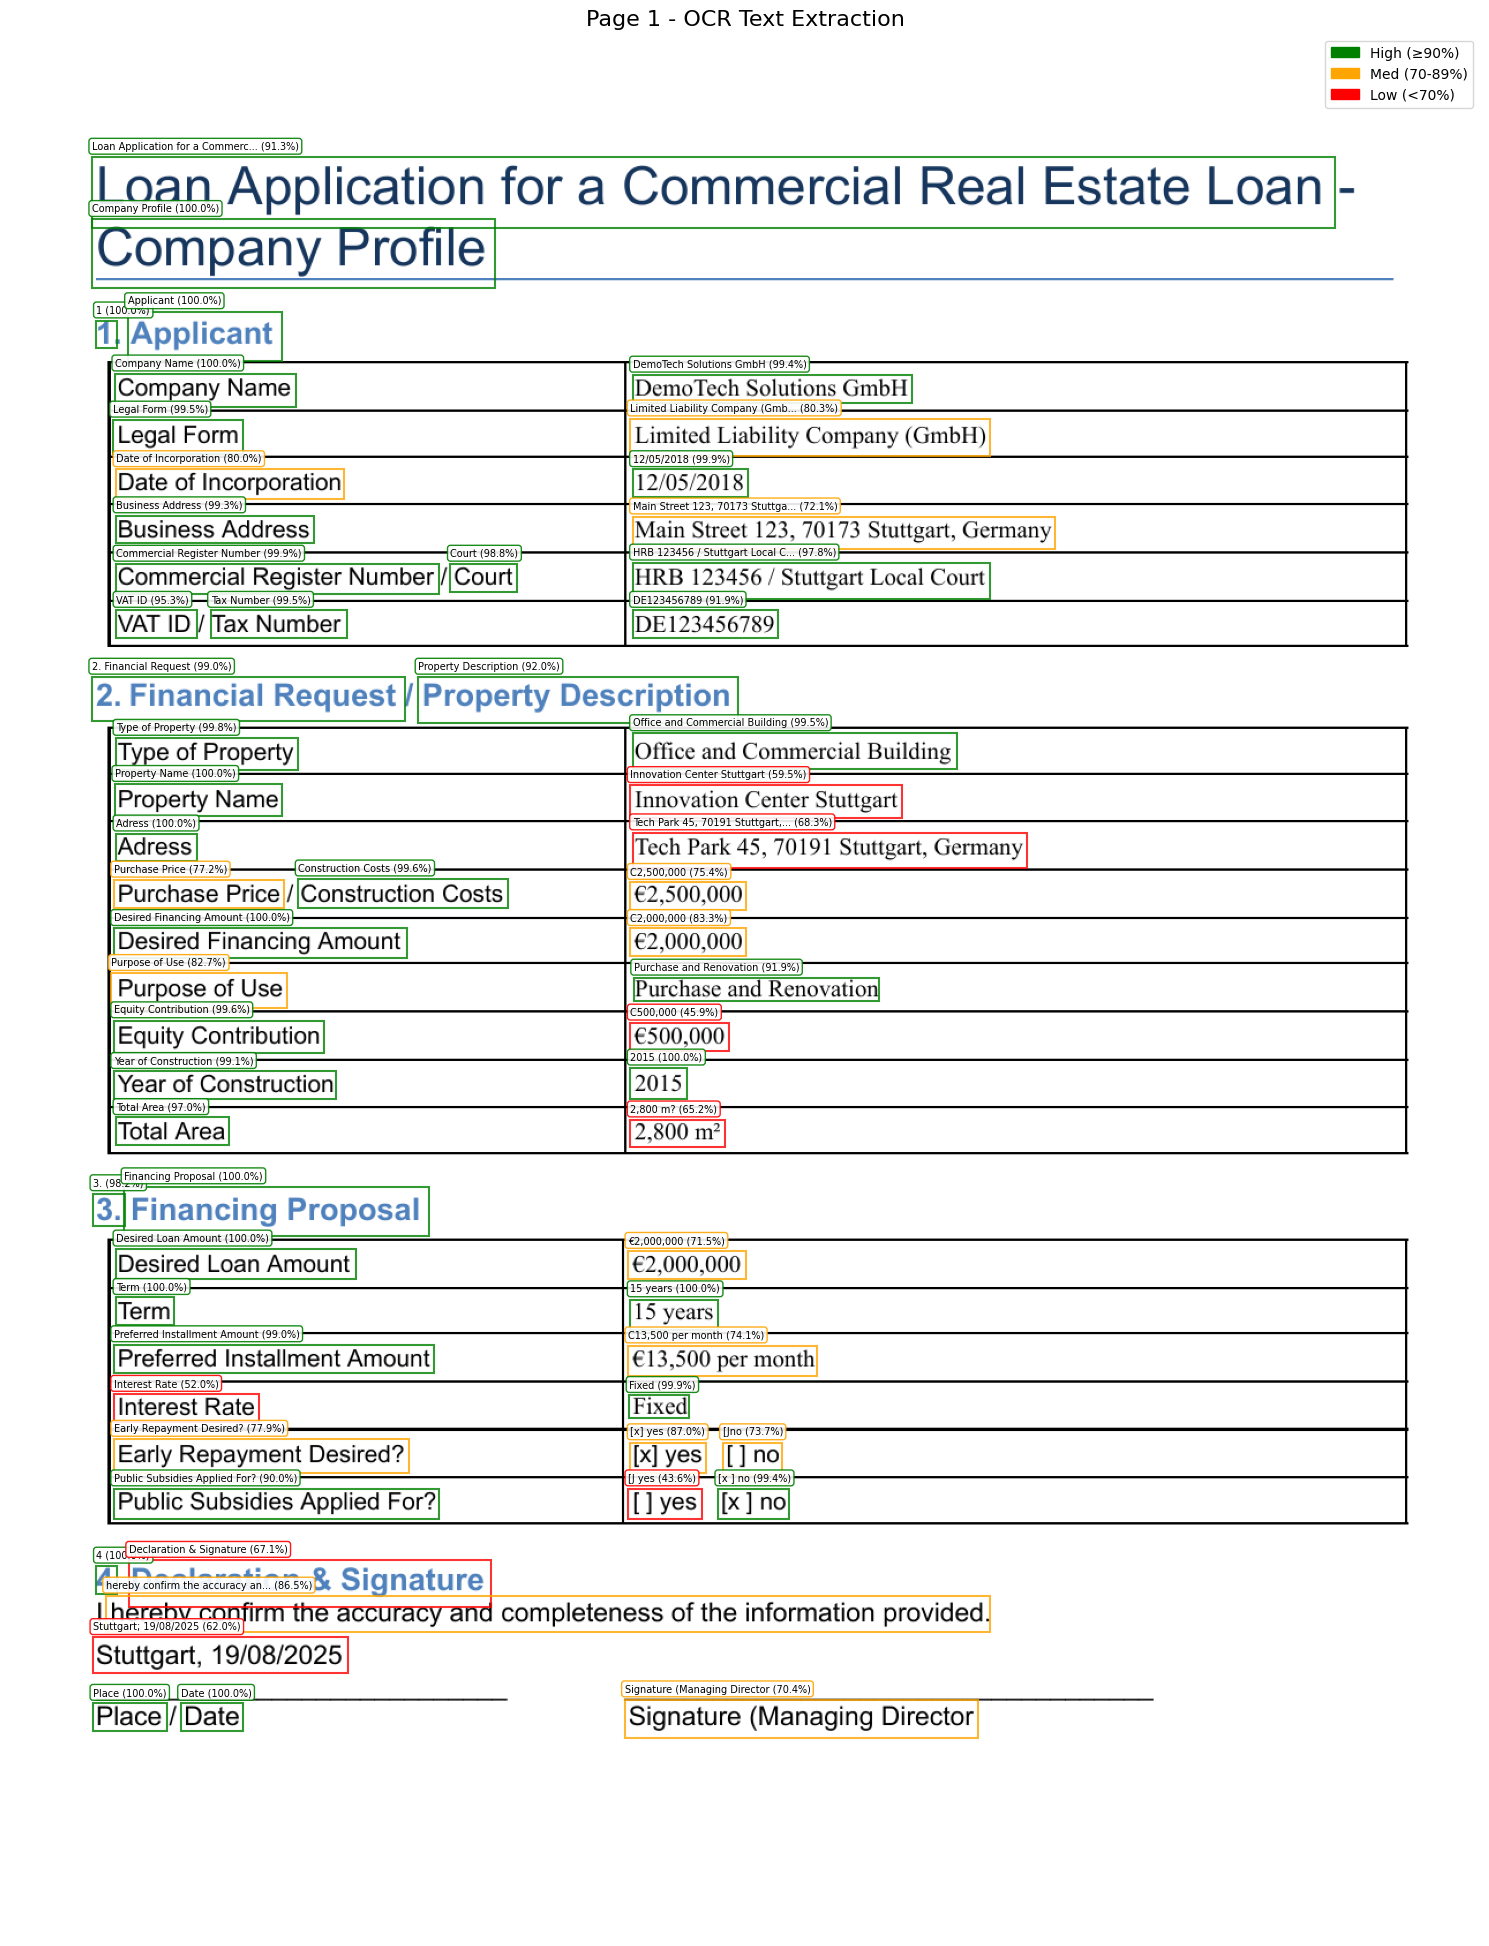

Page 1: 62 elements | Avg: 88.6% | H:40 M:14 L:8
Step 5: Pipeline completed successfully!
  - Extracted 18 fields
  - Missing 0 fields
PIPELINE COMPLETED SUCCESSFULLY!


In [24]:
results = await integrated_pipeline(document_id, filename, blob_path)
print("PIPELINE COMPLETED SUCCESSFULLY!")

'now, we see that this works so we move these functions also to the /src